<a href="https://colab.research.google.com/github/ZzzandyzzZ/FireNet/blob/main/FIRENET_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuracion del entorno



## Tarjeta Gráfica

In [ ]:
!nvidia-smi

Sun Dec 18 23:08:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Librerias

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
import os
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
print(tf.__version__)

2.9.2


## Conexión a Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!touch ~/.kaggle/kaggle.json

api_token = {"username":"andyacarodriguez","key":"09a0670c5fb75b38afcfb1c8d36655da"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d phylake1337/no-fire-dataset

403 - Forbidden


In [ ]:
import os
os.chdir("/content/drive/My Drive/UNSA/11 semestre/FireNet")
!ls

'Copia de Our_Complete_Dataset_Video_and_extra_NoFire_Frames.zip'
'Copia de Training Dataset.zip'
 fire-dataset.zip
 FireNet.ipynb
 full_dataset
 kaggle.json
 model_small.png
 model_small.svg
'Test Dataset'
'Test Dataset.zip'
 TrainedModels
 Untitled0.ipynb
 video_dataset


In [ ]:
IMG_SIZE = 150
DATADIR = 'full_dataset'
CATEGORIES = ['Fire', 'NoFire']
def create_training_data():
    training_data = []
    for category in CATEGORIES:  
        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O
        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return training_data

In [ ]:
def get_data_with_labels(data):
  X = []
  Y = []
  for features,label in data:
      X.append(features)
      Y.append(label)

  X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  X = X/255.0
  Y = np.array(Y)
  return X, Y

In [ ]:
training_data = create_training_data()

100%|██████████| 1983/1983 [00:58<00:00, 33.96it/s]


# Conjunto de datos

In [ ]:
import random
random.shuffle(training_data)
x_data, y_data = get_data_with_labels(training_data)

In [ ]:
size = int(len(x_data)*80/100)

x_train = x_data[:size]
x_test = x_data[size:]

y_train = y_data[:size]
y_test = y_data[size:]
print(len(x_data),size)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

4452 3561
3561 891
3561 891


In [ ]:
DATADIR = 'Test Dataset'
testing_data = create_training_data()

100%|██████████| 278/278 [00:12<00:00, 23.04it/s]


In [ ]:
import random
random.shuffle(testing_data)

In [ ]:
VAL_PERCENTAGE = 40
x_test, y_test = get_data_with_labels(testing_data)
VAL_SIZE = int(40/100*len(testing_data))
x_val = x_test[:VAL_SIZE]
y_val = y_test[:VAL_SIZE]
print(y_val[:20])

testing_data = testing_data[VAL_SIZE:]

[0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1]


# Aumento de datos

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

rango_rotacion = 30
mov_ancho = 0.1
mov_alto = 0.1
#rango_inclinacion=15 #No uso este de momento pero si quieres puedes probar usandolo!
rango_acercamiento=[0.5,1.5]

datagen = ImageDataGenerator(
    rotation_range = rango_rotacion,
    width_shift_range = mov_ancho,
    height_shift_range = mov_alto,
    zoom_range=rango_acercamiento,
    #shear_range=rango_inclinacion #No uso este de momento pero si quieres puedes probar usandolo!
)

datagen.fit(X)

ANTES:



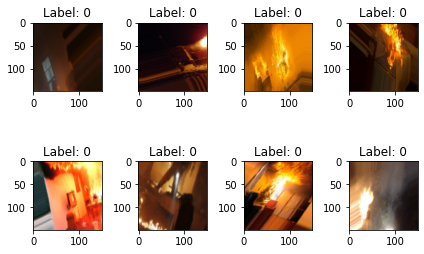

DESPUES:



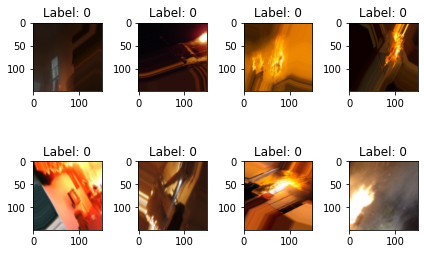

In [ ]:
filas = 2
columnas = 4
num = filas*columnas
print('ANTES:\n')
fig1, axes1 = plt.subplots(filas, columnas, figsize=(1.5*columnas,2*filas))
for i in range(num):
     ax = axes1[i//columnas, i%columnas]
     ax.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB ))
     ax.set_title('Label: {}'.format(np.argmax(Y[i])))
plt.tight_layout()
plt.show()
print('DESPUES:\n')
fig2, axes2 = plt.subplots(filas, columnas, figsize=(1.5*columnas,2*filas))
for X, Y in datagen.flow(X,Y,batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//columnas, i%columnas]
          ax.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB ))
          ax.set_title('Label: {}'.format(int(np.argmax(Y[i]))))
     break
plt.tight_layout()
plt.show()

# Creación del modelo

In [ ]:
prop_model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Conv2D(128, (3,3), activation='relu'),
    # BatchNormalization(),

    Conv2D(128, (3,3), activation='relu',padding='same' ),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
  
    Dense(256, activation='relu'),
    Dropout(0.6),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.15),

    Dense(32, activation='relu'),
    Dropout(0.075),

    Dense(16, activation='relu'),
    Dropout(0.0325),
  
    # Dense(units=1, activation = 'sigmoid'),
    Dense(units=2, activation = 'softmax'),
])
prop_model.compile(optimizer='adam',
              # loss='binary_crossentropy',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
orig_model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    AveragePooling2D(),
    Dropout(0.5),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    Dropout(0.5),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dense(units=2, activation = 'softmax'),
])

orig_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
prop_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_25 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_26 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                     

In [ ]:
orig_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 average_pooling2d_18 (Avera  (None, 31, 31, 16)       0         
 gePooling2D)                                                    
                                                                 
 dropout_54 (Dropout)        (None, 31, 31, 16)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 average_pooling2d_19 (Avera  (None, 14, 14, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_55 (Dropout)        (None, 14, 14, 32)      

# Entrenamiento del modelo

In [ ]:
prop_history = prop_model.fit(x_train, y_train, batch_size=32, epochs=70, validation_split=0.3)

In [ ]:
orig_history = orig_model.fit(x_train, y_train, batch_size=30, epochs=80, validation_split=0.3)

In [ ]:
prop_model.save('TrainedModels/prop_model_70e_md_v2.h5')
orig_model.save('TrainedModels/orig_model_80e_md.h5')

# Métricas de evaluación

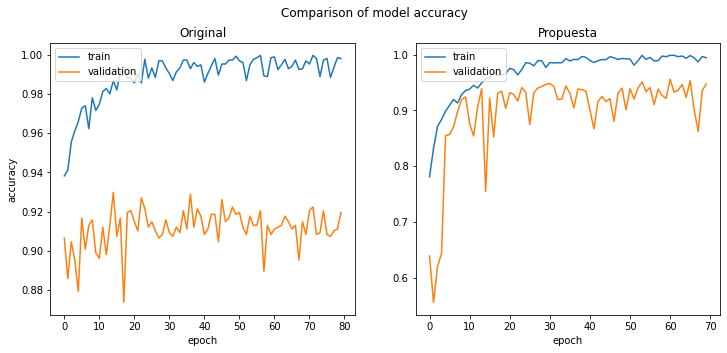

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Comparison of model accuracy')
for i, history in enumerate([orig_history, prop_history]):
  axs[i].plot(history.history['accuracy'])
  axs[i].plot(history.history['val_accuracy'])
  axs[0].set_ylabel('accuracy')
  axs[i].set_title('Original' if i == 0 else 'Propuesta')
  axs[i].set_xlabel('epoch')
  axs[i].legend(['train', 'validation'], loc='upper left')
plt.show()

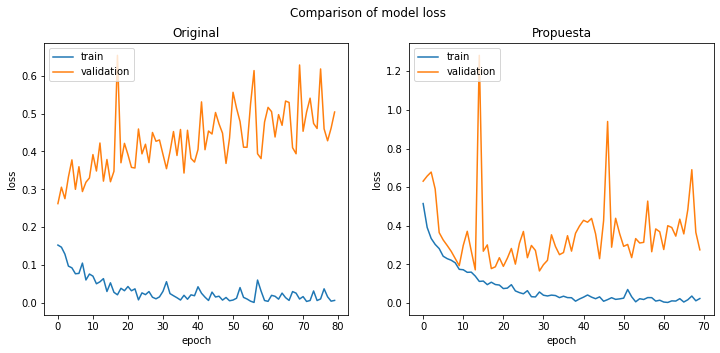

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Comparison of model loss')
for i, history in enumerate([orig_history, prop_history]):
  axs[i].plot(history.history['loss'])
  axs[i].plot(history.history['val_loss'])
  axs[i].set_title('Original' if i == 0 else 'Propuesta')
  axs[i].set_ylabel('loss')
  axs[i].set_xlabel('epoch')
  axs[i].legend(['train', 'validation'], loc='upper left')

# Validación de resultados

In [ ]:
!unzip 'Copia de Our_Complete_Dataset_Video_and_extra_NoFire_Frames.zip'

In [ ]:
import random
from sklearn.metrics import confusion_matrix
import itertools
# x_test, y_test 
test_size = len(x_test)
test_labels=np.zeros((test_size,1))

c=0
for sample in y_test:
    test_labels[c]=sample
    c+=1
actual_labels=(test_labels.reshape(test_size,))
actual_labels.astype(int)
print(actual_labels.shape)

(891,)


In [ ]:
predicted_labels_orig=orig_model.predict(x_test)
predicted_labels_orig_bi = []
for i in predicted_labels_orig:
    predicted_labels_orig_bi.append(0 if i[0] > i[1] else 1)
print(predicted_labels_orig_bi[0])
predicted_labels_prop=prop_model.predict(x_test)
predicted_labels_prop_bi = []
for i in predicted_labels_prop:
    predicted_labels_prop_bi.append(0 if i[0] > i[1] else 1)
print(predicted_labels_prop_bi[0])
# predicted_labels_prop=prop_model.predict(x_test)
# predicted_labels=(predicted_labels_prop.reshape(test_size,))
# predicted_labels_prop = predicted_labels_prop.astype(int)
# print(predicted_labels_prop[:10], actual_labels[:10])

28/28 [==============================] - 0s 8ms/step
0
28/28 [==============================] - 0s 12ms/step
0


<class 'numpy.ndarray'> [[465  18]
 [ 53 355]]
2
2


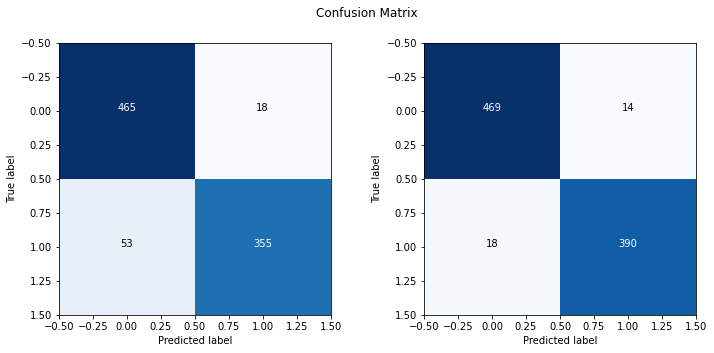

In [ ]:
def plot_confusion_matrix(cm_arr, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle(title)
    for i, cm in enumerate(cm_arr):
      axs[i].imshow(cm, interpolation='nearest', cmap=cmap)
      axs[i].set_ylabel('True label')
      axs[i].set_xlabel('Predicted label')
      fmt = 'd'
      thresh = cm.max() / 2.
      print(cm.shape[0])
      for j, k in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axs[i].text(k, j, format(cm[j, k], fmt),
                 horizontalalignment="center",
                 color="white" if cm[j, k] > thresh else "black")
cm_orig = confusion_matrix(actual_labels, predicted_labels_orig_bi)
cm_prop = confusion_matrix(actual_labels, predicted_labels_prop_bi)
print(type(cm_orig),cm_orig)
#test_batches.class_indices
cm_plot_labels=['Fire','No Fire']
plot_confusion_matrix([cm_orig, cm_prop], cm_plot_labels,title='Confusion Matrix')

In [ ]:
for cm in [cm_orig, cm_prop]:
  tp=cm[0][0]
  fn=cm[0][1]
  fp=cm[1][0]
  tn=cm[1][1]
  print("tp"+' '+str(tp))
  print("fn"+' '+str(fn))
  print("fp"+' '+str(fp))
  print("tn"+' '+str(tn))
  Recall=tp/(tp+fn)
  Precision=tp/(tp+fp)
  f_measure= 2*((Precision*Recall)/(Precision+Recall))

  print(Precision, Recall, f_measure)

tp 465
fn 18
fp 53
tn 355
0.8976833976833977 0.9627329192546584 0.929070929070929
tp 469
fn 14
fp 18
tn 390
0.9630390143737166 0.9710144927536232 0.9670103092783506


In [ ]:
!wget https://www.freefontspro.com/d/14454/arial.zip

--2022-12-19 03:59:49--  https://www.freefontspro.com/d/14454/arial.zip
Resolving www.freefontspro.com (www.freefontspro.com)... 172.67.153.204, 104.21.90.75, 2606:4700:3033::6815:5a4b, ...
Connecting to www.freefontspro.com (www.freefontspro.com)|172.67.153.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529068 (517K) [application/zip]
Saving to: ‘arial.zip’

arial.zip           100%[===================>] 516.67K   687KB/s    in 0.8s    

2022-12-19 03:59:50 (687 KB/s) - ‘arial.zip’ saved [529068/529068]



In [ ]:
!ls

 1_19tmLBmVPfbohCvb7HgJFg.png
 Arial_font_2021-11-28_14-10-13.jpg
 Arial-Font.jpg
 arial.ttf
 arial.zip
'Copia de Our_Complete_Dataset_Video_and_extra_NoFire_Frames.zip'
'Copia de Training Dataset.zip'
 fire-dataset.zip
 FireNet.ipynb
 full_dataset
 kaggle.json
 model_small.png
 model_small.svg
'Test Dataset'
'Test Dataset.zip'
 TrainedModels
 Untitled0.ipynb
 video_dataset


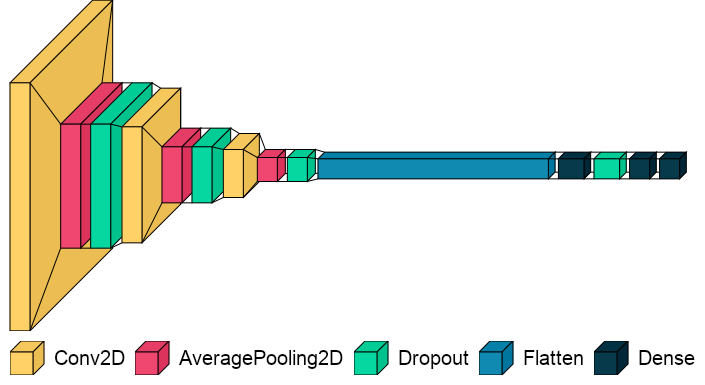

In [ ]:
# !pip install visualkeras
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 20, encoding="unic")
visualkeras.layered_view(orig_model, legend=True, font=font)

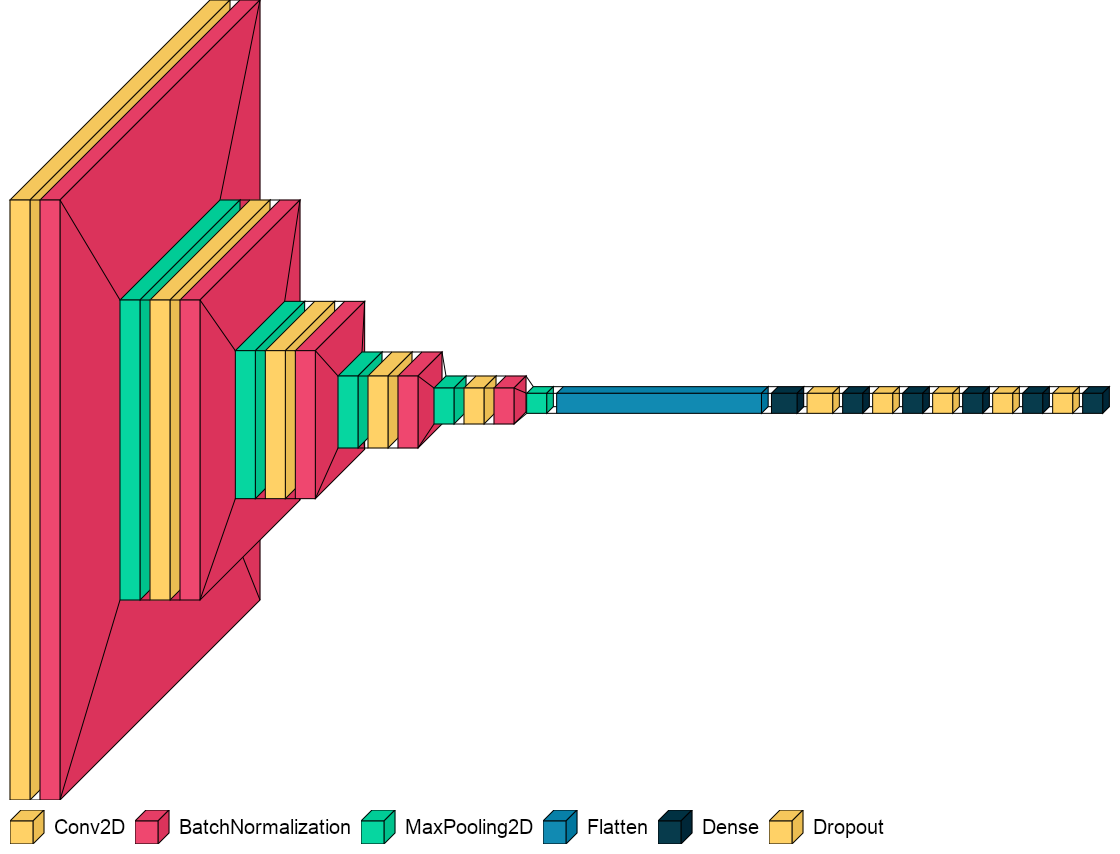

In [ ]:
visualkeras.layered_view(prop_model, legend=True, font=font)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# loading the stored model from file

cap = cv2.VideoCapture(r'video_dataset/fire/FireVid20.mp4')
time.sleep(2)

if cap.isOpened(): # try to get the first frame
    rval, frame = cap.read()
else:
    rval = False


IMG_SIZE = 64
# IMG_SIZE = 224


#for i in range(2500):
#    cap.read()



while(1):

    rval, image = cap.read()
    if rval==True:
        orig = image.copy()
        
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        
        tic = time.time()
        fire_prob = model.predict(image)[0][0] * 100
        toc = time.time()
        print("Time taken = ", toc - tic)
        print("FPS: ", 1 / np.float64(toc - tic))
        print("Fire Probability: ", fire_prob)
        print("Predictions: ", model.predict(image))
        print(image.shape)
        
        label = "Fire Probability: " + str(fire_prob)
        cv2.putText(orig, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)

        cv2_imshow("Output", orig)
        plt.imshow(image)
        plt.show()
        key = cv2.waitKey(10)
        if key == 27: # exit on ESC
            break
    elif rval==False:
            break
end = time.time()


cap.release()
cv2.destroyAllWindows()